<center>
<h1>STAT 654: Statistical Computing with R and Python</h1>
<h2>Bayesian Computations: Gibbs Samplers</h2>
<strong>
Daniel Drennan<br>
Professor Sharmistha Guha<br><br>
Department of Statistics<br>
Texas A&M University<br>
College Station, TX, USA<br><br>
Spring 2022<br>
</strong>
</center>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

## Introduction

This notebook translates the file `Gibbs.R` from R into Python. The mathematical details of finding the posterior distribution
and its conditional distributions are saved as a homework exercise. You may find Section 3.3 of *Bayesian Data Analysis* by
Gelman et al. helpful when working out this problem.
(It starts on page 77 of the [pdf here](http://www.stat.columbia.edu/~gelman/book/BDA3.pdf).)

Step one is generating a dataset and plotting it (do this with a random seed). The model we'll simulate is
$$
    y_1, \ldots, y_{500} \overset{iid}{\sim} N(3, 1).
$$

In [2]:
# Data generation
np.random.seed(654)
# True parameters
mu, sigma = 3, 1
n = 500
y = stats.norm(mu, sigma).rvs(n)
ybar = y.mean()

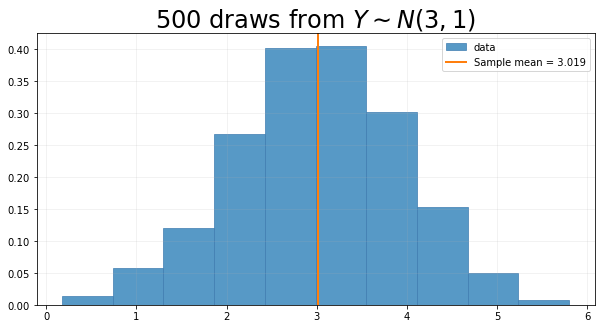

In [3]:
plt.figure(figsize = (10, 5))
plt.title("500 draws from $Y \sim N(3, 1)$", fontsize=24)
plt.hist(y, color = 'C0', density = True, edgecolor = 'steelblue', alpha = 0.75, label = "data")
plt.axvline(x = ybar, color = 'C1', lw = 2, label = f"Sample mean = {ybar:.3f}")
plt.legend()
plt.grid(alpha = 0.2)
plt.show()

The histogram above is plotted with the sample mean for the data. The histogram of the data is symmetric around 3 with a range
of about zero to six. Using the range rule to estimate the standard deviation, $\sigma \approx 6 / 4 = 1.5$. The sample mean is
around 3 looking at the data. I'll use the sample statistics to initialize the Markov chain, although this is a graphical way to
estimate the values from any distribution.

The next two code blocks set up the Markov chain and actually run it. I've separated the setup from the implementation to
emphasize each part. In principle, one could use a single matrix to store all of the values simulated. The trick then would be
to use a single matrix `theta = np.empty((N, p))`, where `p` is the number of parameters in the posterior distribution. The code
would look similar except we would store new values of $\mu$ in, say, `theta[_, 0]` and $\sigma^2$ in `theta[_, 1]`. The main
point would be to have simulations in the rows and parameters in the columns of the simulated matrix.

In [4]:
# Markov chain simulation setup
# Length of the Markov chain and burn-in rate
N = 10000
B =  5000

# Store all parameters in one matrix
mu = np.empty(N)
sigma2 = np.empty(N)

# I am initializing at the summary statistics, which should be close to the
# posterior estimates in most problems. This is different from the initialization
# used in the R example.
mu[0] = y.mean()
sigma2[0] = y.std()

Sampling the chain should be done separately from any plotting or other computations on the posterior distribution. The actual
Gibbs sampler takes about 15 seconds to run on my machine. For more complex models and a longer number of iterations, it would
of course take longer. As a result, it is a good idea to run samples either in their own script and export the results to a file
or to run them in a code block by themselves.

In [5]:
# Gibbs sampler implementation
# Note both conditional distributions involve conditioning on the value of other parameters
# in the posterior distribution
for _ in range(1, N):
    # The conditional posterior for mu is a normal
    mu[_] = stats.norm(ybar, sigma2[_-1]/n).rvs()
    s = np.sum((y - mu[_])**2) / 2
    # The conditional posterior for sigma2 is an inv-gamma distribution
    sigma2[_] = stats.invgamma(a = n/2, scale = s).rvs()

Once the chains have been simulated, diagnostic plots need to be produced. The bare minimum here are traceplots with samples
by iteration number and autocorrelation plots. Traceplots can be put in one graph, but I sometimes prefer to make subplots for
them. ACF plots are the same. In both cases, use all of the MCMC samples. You can plot these using the entire chain or start
plotting from the burn in point. The burn-in is good to see when you reach stationarity, after the burn-in, you see only samples
from the posterior distribution.

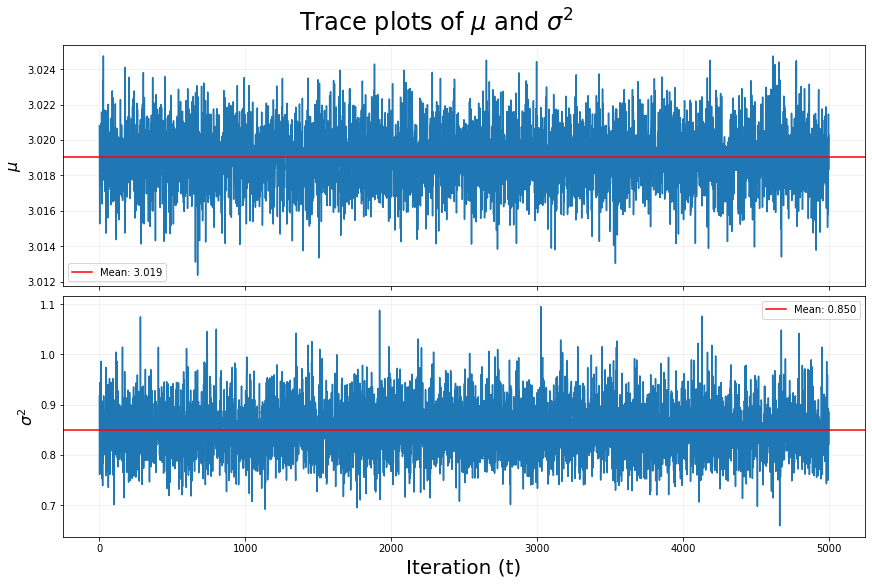

In [6]:
fig, ax = plt.subplots(2, 1, figsize = (12, 8), sharex=True, constrained_layout=True)
fig.suptitle("Trace plots of $\\mu$ and $\sigma^2$", fontsize = 24)
ax[0].plot(mu[B+1:])
ax[0].axhline(mu[B+1:].mean(), color = 'r', label = f"Mean: {mu[B+1:].mean():.3f}")
ax[0].legend()
ax[0].grid(alpha = 0.2)
ax[0].set_ylabel("$\\mu$", fontsize = 16)

ax[1].plot(sigma2[B+1:])
ax[1].axhline(sigma2[B+1:].mean(), color = 'r', label = f"Mean: {sigma2[B+1:].mean():.3f}")
ax[1].legend()
ax[1].grid(alpha = 0.2)
ax[1].set_ylabel("$\sigma^2$", fontsize = 16)
ax[1].set_xlabel("Iteration (t)", fontsize = 20)
plt.show()

The trace plots appear stationary starting around the initialization. This is not surprising given the simplicity of the model.
Next, we look at autocorrelation plots. I recommend using the `plot_acf` function from statsmodels for this. 

Text(0.5, 0, '$\\sigma^2$')

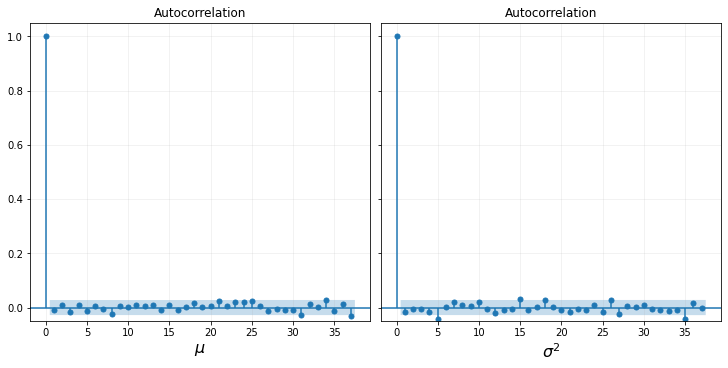

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True, constrained_layout = True)
plot_acf(mu[B+1:], ax[0])
plot_acf(sigma2[B+1:], ax[1])
ax[0].grid(alpha = 0.2)
ax[0].set_xlabel("$\\mu$", fontsize = 16)
ax[0].set_ylim((-0.05, 1.05))
ax[1].grid(alpha = 0.2)
ax[1].set_xlabel("$\sigma^2$", fontsize = 16)

Both ACF plots give little evidence of autocorrelation in the chain. Thus, we can use all of the samples after the burn-in to
calculate estimates from the posterior distribution.

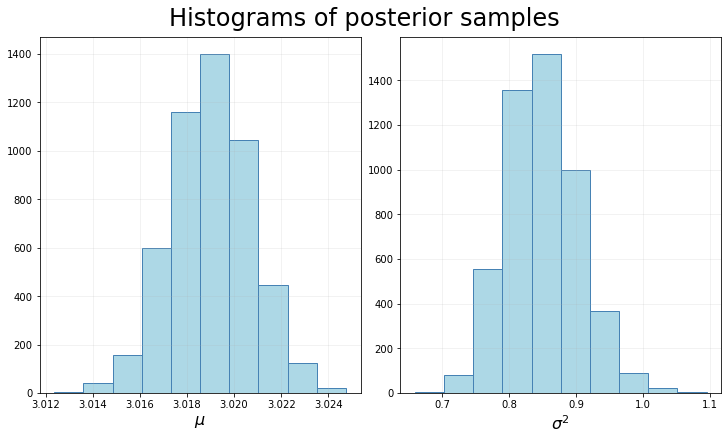

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6), constrained_layout = True)
fig.suptitle("Histograms of posterior samples", fontsize = 24)
ax[0].hist(mu[B+1:], color = "lightblue", edgecolor = "steelblue")
ax[0].set_xlabel("$\\mu$", fontsize = 16)
ax[0].grid(alpha = 0.2)
ax[1].hist(sigma2[B+1:], color = "lightblue", edgecolor = "steelblue")
ax[1].set_xlabel("$\sigma^2$", fontsize = 16)
ax[1].grid(alpha = 0.2)

plt.show()

Another plot which isn't possible in general is a joint plot of the distribution. This is difficult to do in general, but in
a two parameter model it is easy. The arviz and seaborn libraries both have tools for making these, although `arviz` is
built to use outputs from an HMC sampler (pymc3 or stan). For a custom-built sampler, it may be easier to use a more flexible
plotting library than the ones mentioned.

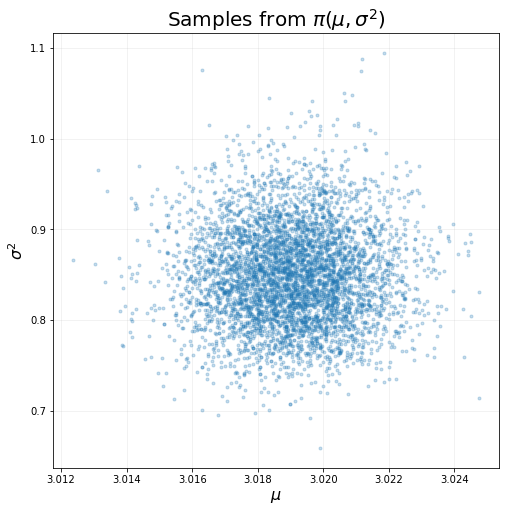

In [9]:
plt.figure(figsize = (8, 8))
plt.title("Samples from $\pi(\\mu, \sigma^2)$", fontsize = 20)
plt.xlabel("$\\mu$", fontsize = 16)
plt.ylabel("$\sigma^2$", fontsize = 16)
plt.plot(mu[B+1:], sigma2[B+1:], '.', alpha = 0.25)
plt.grid(alpha = 0.2)
plt.show()

In homework, I'd recommend making versions of all of these plots. For R users, you may want to store the data in a tibble and
use dplyr with ggplot2 to make the graphs. There are cheat sheets for those packages in RStudio (under help), and they also
provide a consolidated reference for them at 
[https://www.rstudio.com/resources/cheatsheets/](https://www.rstudio.com/resources/cheatsheets/).